In [2]:
# !pip install neuralforecast
# !pip install mlforecast
# !pip install statsforecast

In [2]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingStd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import time
import os
from mlforecast.target_transforms import Differences
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('data_new/coldstart.xlsx')
df['unique_id'] = 1
df = df[df['Hour'].between(8,17)]
df['IsBreak'] = np.where(df['Hour'] == 12, 1, 0)
df['time_idx'] = range(1, len(df)+1)
df = pd.get_dummies(df, columns=['Hour'])
df.head()

,DateTime,Day,Latency,Request,CPU_Usage,Memory_Usage,unique_id,IsBreak,time_idx,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17
96,2023-03-01 08:00:00,1,845,95,100,100,1,0,1,1,0,0,0,0,0,0,0,0,0
97,2023-03-01 08:05:00,1,18,90,98,80,1,0,2,1,0,0,0,0,0,0,0,0,0
98,2023-03-01 08:10:00,1,21,56,63,39,1,0,3,1,0,0,0,0,0,0,0,0,0
99,2023-03-01 08:15:00,1,19,91,97,77,1,0,4,1,0,0,0,0,0,0,0,0,0
100,2023-03-01 08:20:00,1,18,86,93,76,1,0,5,1,0,0,0,0,0,0,0,0,0


# Create Train & Test Datasets (4 Train / 4 Test)

### Multistep Datasets

In [62]:
TRAIN_LEN = 600
PRED_LEN = 4

temp_df = df[(df['Day'] == 6) & (df['Request'] > 99)]
temp_df['IsLatenctGT800'] = np.where(temp_df['Latency'] >= 800, 1, 0)
cold_start_time_indices = temp_df[temp_df['IsLatenctGT800'] == 1]['time_idx'].values

train_dfs = []
test_dfs = []

for idx in cold_start_time_indices:
    train_end_time_idx = idx - PRED_LEN - 1
    train_start_time_idx = train_end_time_idx - TRAIN_LEN
    test_start_time_idx = idx - PRED_LEN
    test_end_time_idx = idx

    # print(train_start_time_idx, train_end_time_idx)
    # print(test_start_time_idx, test_end_time_idx)
    # display(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)].tail())
    # display(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

    train_dfs.append(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)])
    test_dfs.append(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

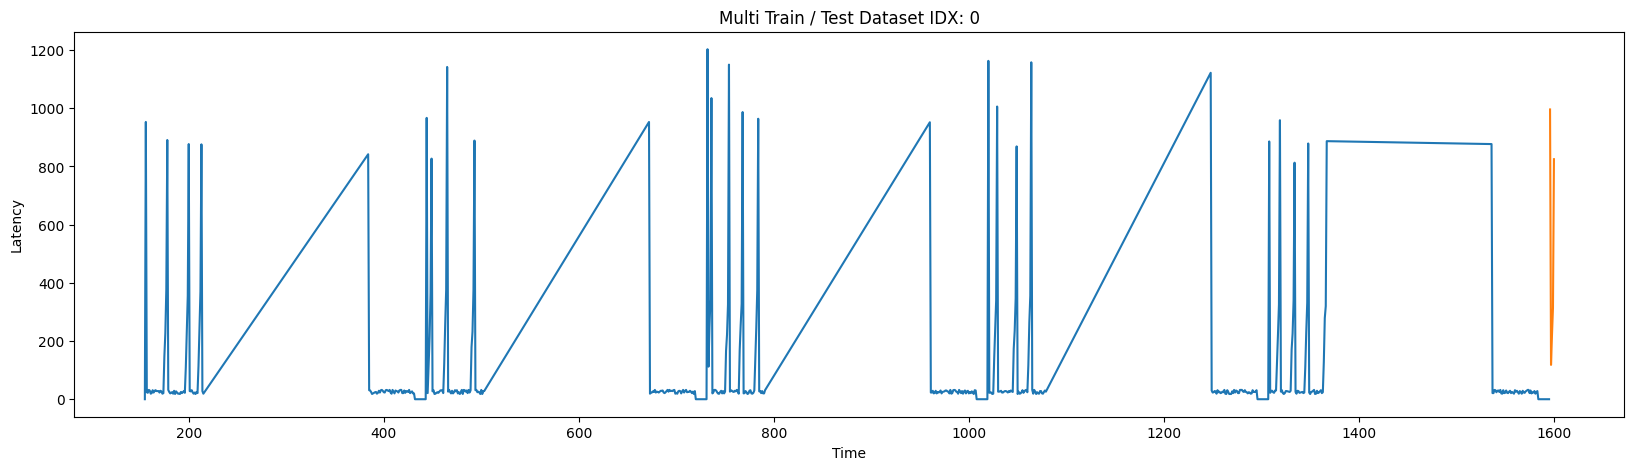

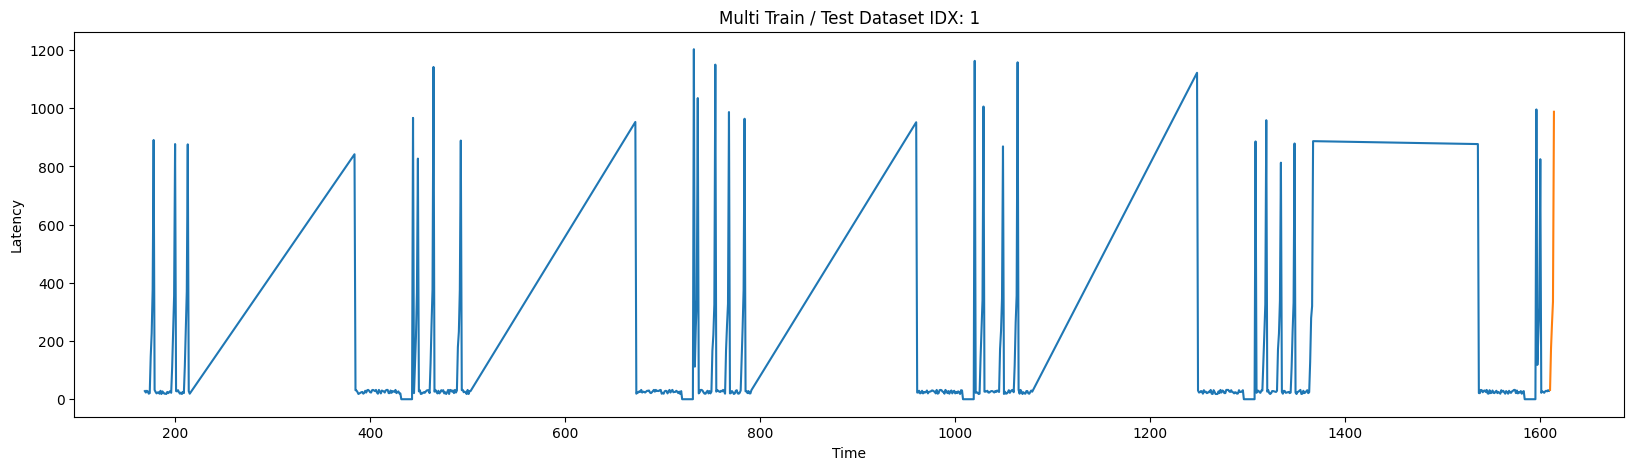

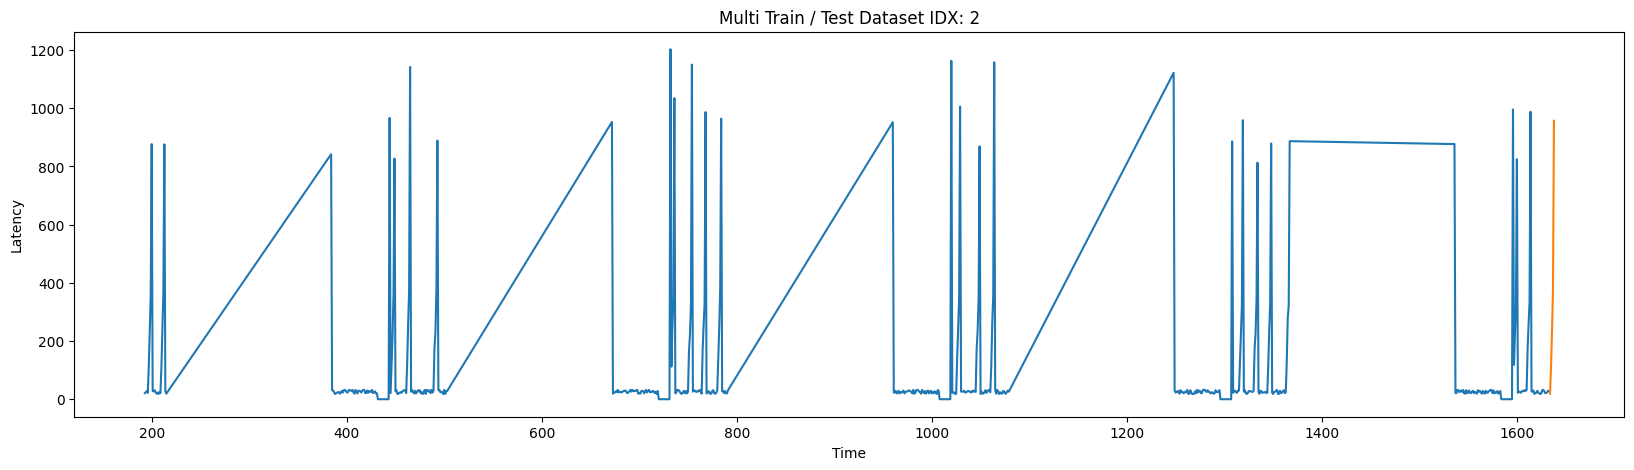

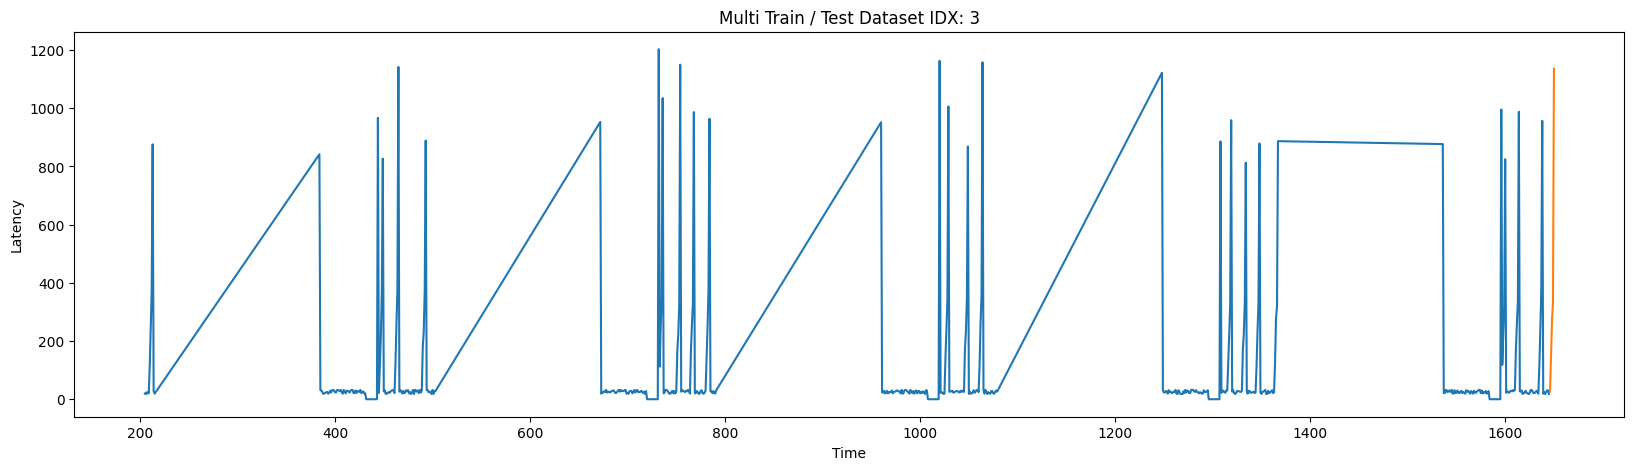

In [63]:
for i in range(len(train_dfs)):
    train_dfs[i]['Latency'].plot(figsize=(20,5), title=f'Multi Train / Test Dataset IDX: {i}')
    test_dfs[i]['Latency'].plot()
    plt.xlabel("Time")
    plt.ylabel("Latency")
    plt.show()

In [64]:
for i in range(len(train_dfs)):
    train_dfs[i].to_excel(f'data_new/multistep_train_{i}.xlsx', index=False)
    test_dfs[i].to_excel(f'data_new/multistep_test_{i}.xlsx', index=False)

### SingeStep Datasets

In [65]:
TRAIN_LEN = 600
PRED_LEN = 1

temp_df = df[(df['Day'] == 6) & (df['Request'] > 99)]
temp_df['IsLatenctGT800'] = np.where(temp_df['Latency'] >= 800, 1, 0)
cold_start_time_indices = temp_df[temp_df['IsLatenctGT800'] == 1]['time_idx'].values

train_dfs = []
test_dfs = []

for idx in cold_start_time_indices:
    train_end_time_idx = idx - PRED_LEN
    train_start_time_idx = train_end_time_idx - TRAIN_LEN
    test_start_time_idx = idx
    test_end_time_idx = idx

    # print(train_start_time_idx, train_end_time_idx)
    # print(test_start_time_idx, test_end_time_idx)
    # display(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)].tail())
    # display(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

    train_dfs.append(df[df['time_idx'].between(train_start_time_idx, train_end_time_idx)])
    test_dfs.append(df[df['time_idx'].between(test_start_time_idx, test_end_time_idx)])

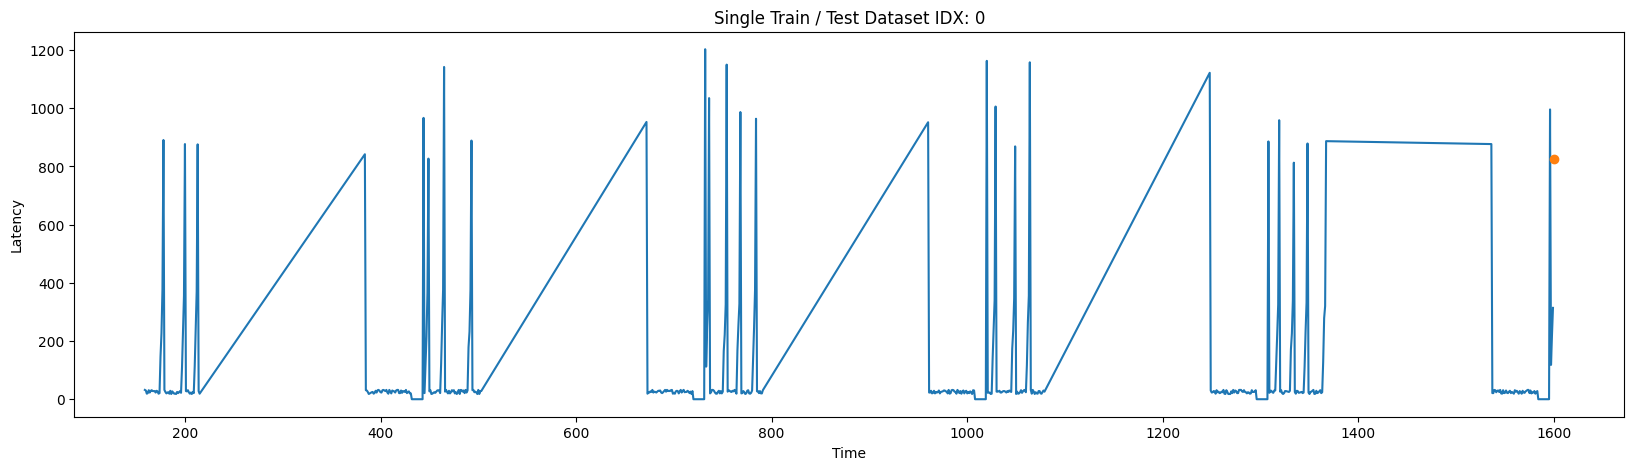

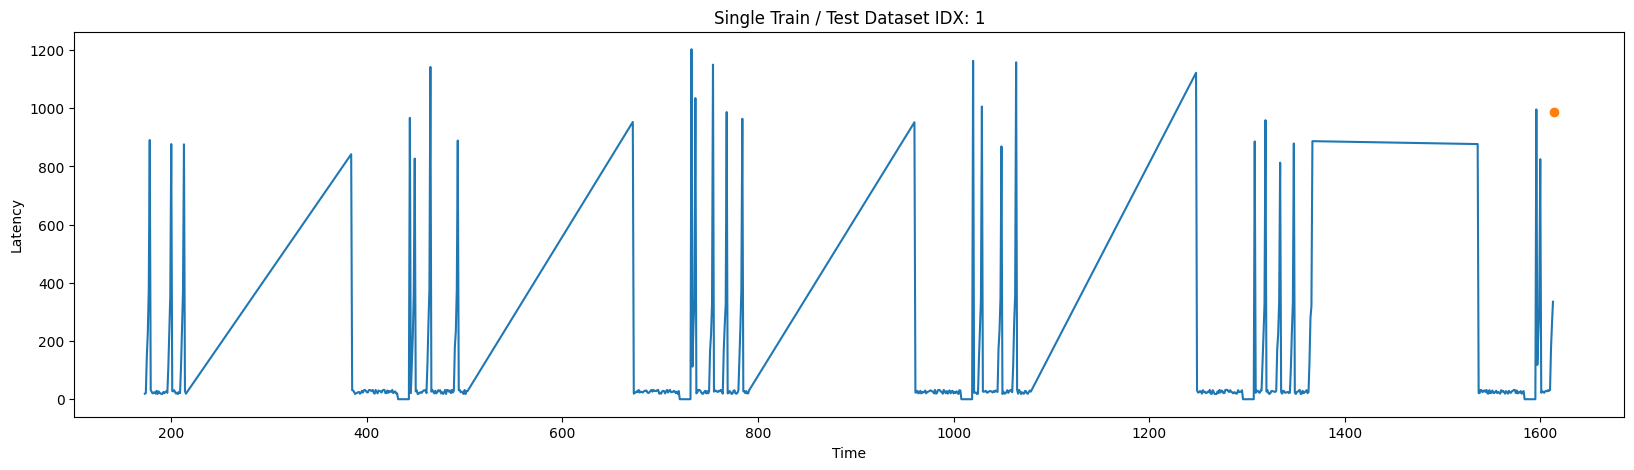

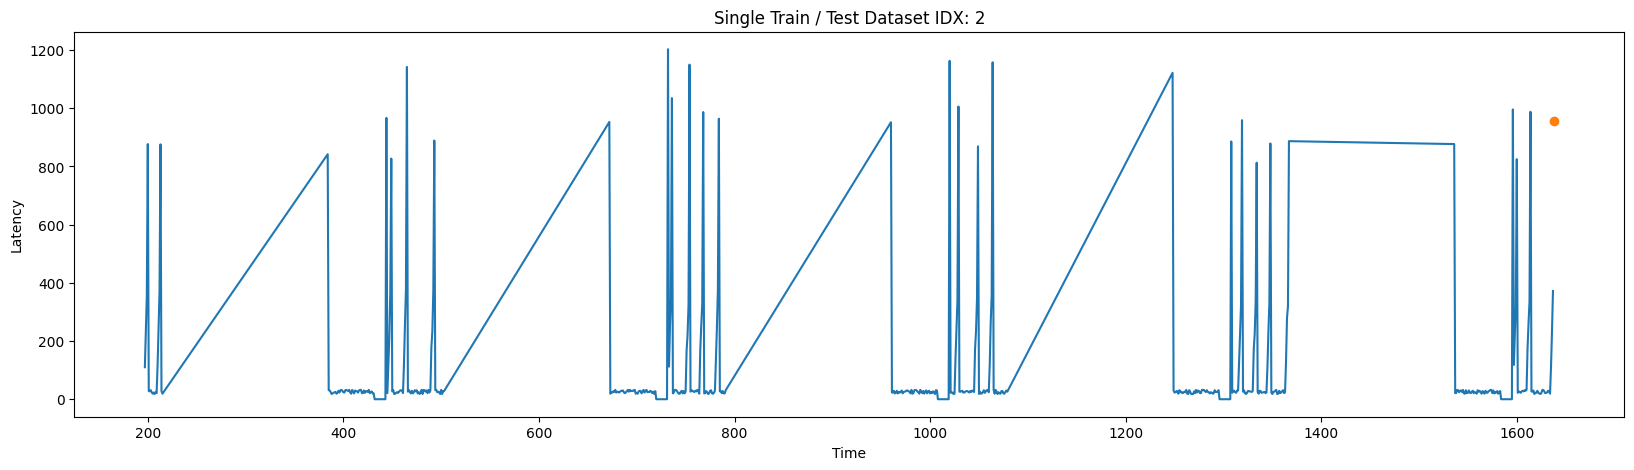

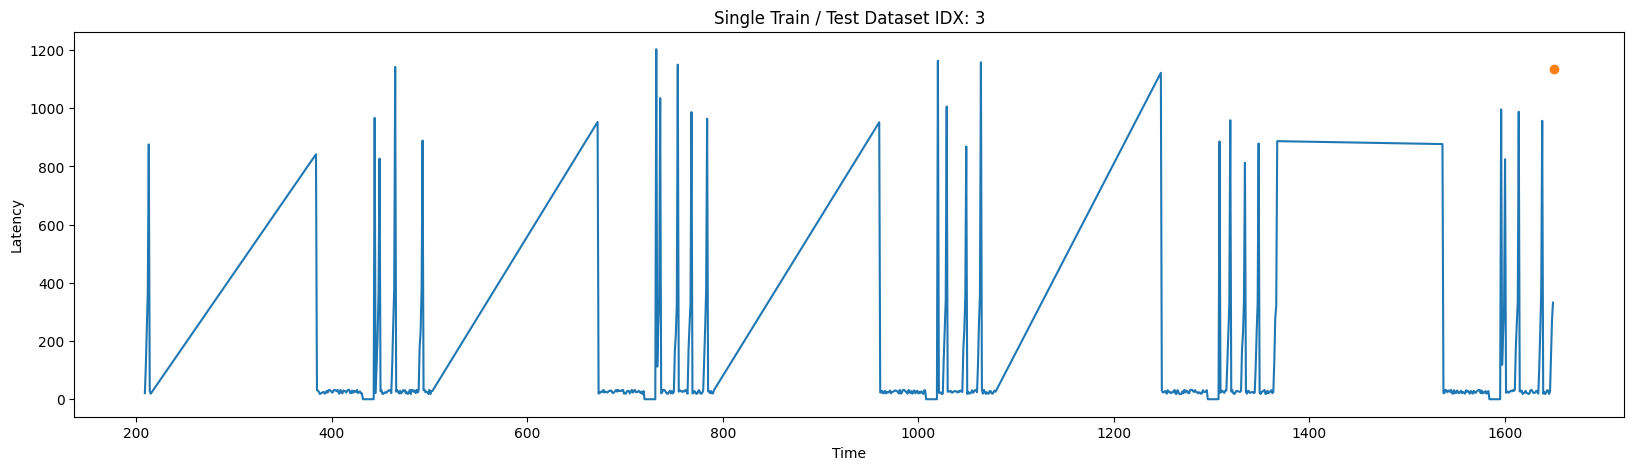

In [66]:
for i in range(len(train_dfs)):
    train_dfs[i]['Latency'].plot(figsize=(20,5), title=f'Single Train / Test Dataset IDX: {i}')
    test_dfs[i]['Latency'].plot(marker='o')
    plt.xlabel("Time")
    plt.ylabel("Latency")
    plt.show()

In [67]:
for i in range(len(train_dfs)):
    train_dfs[i].to_excel(f'data_new/singlestep_train_{i}.xlsx', index=False)
    test_dfs[i].to_excel(f'data_new/singlestep_test_{i}.xlsx', index=False)

# ML Approach (LGBM, XGB, RND)

In [4]:
all_multistep_results = []
dataset_idx_list = list(range(4))
DATASET_MAIN_DIR = 'data_new'
TARGET = 'Latency'
ID_COL = 'unique_id'
TIME_COL = 'time_idx'
SEED = 33
models = [
        LGBMRegressor(random_state=SEED),
        XGBRegressor(random_state=SEED),
        RandomForestRegressor(random_state=SEED),
        #LinearRegression()
    ]
for model in models:
    print(model.__class__.__name__)
    print(model.get_params())
    print('='*50)

LGBMRegressor
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 33, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
XGBRegressor
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'mi

### ML-MultiStep

In [5]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['Day', 'DateTime'], axis=1)

    for model in models:
        mlf = MLForecast(
            models = model,
            lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            freq = 1,
            target_transforms=[Differences([5])],
            lag_transforms={
            1: [ExpandingStd()],
            #3: [RollingMean(window_size=3, min_samples=1)],
            6: [RollingMean(window_size=6, min_samples=1)],
            #9: [RollingMean(window_size=3, min_samples=1)],
            #12: [RollingMean(window_size=12, min_samples=1)]
            },
        )
        train[ID_COL] = train[ID_COL].astype(int)
        test[ID_COL] = test[ID_COL].astype(int)
        t1 = time.perf_counter()
        mlf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])
        t2 = time.perf_counter()
        #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
        preds = mlf.predict(len(test), X_df=test.drop(TARGET, axis=1))
        t3 = time.perf_counter()
        # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
        preds = preds.merge(test, on=['time_idx', 'unique_id'])
        metrics_dict = {}
        metrics_dict['Fold'] = counter
        metrics_dict['Fold_TrainTime'] = t2-t1
        metrics_dict['Fold_PredictTime'] = t3-t2
        # for estimator in models:
        estimator_name = model.__class__.__name__
        preds[estimator_name] = preds[estimator_name].astype(int)
        metrics_dict['Model'] = estimator_name
        metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
        metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
        multistep_model_metrics.append(metrics_dict)

        filt_preds = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
        filt_preds['Fold'] = counter
        filt_preds['Model'] = estimator_name
        all_multistep_results.append(filt_preds)
        # display(filt_preds)
        if counter == 4:
            multistep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
            multistep_last_fold_df['Model'] = estimator_name
            test = pd.read_excel(test_path)
            multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
            multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1

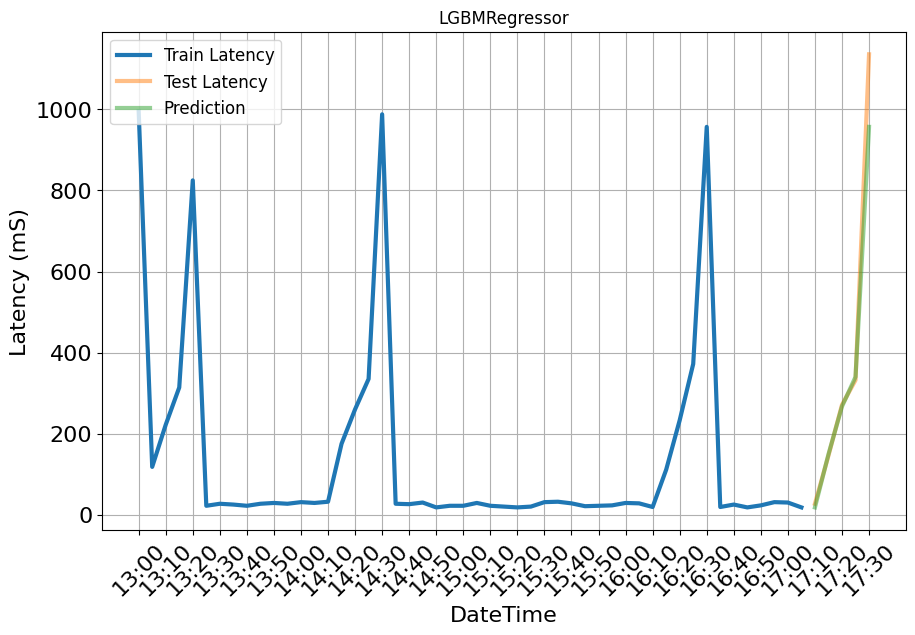

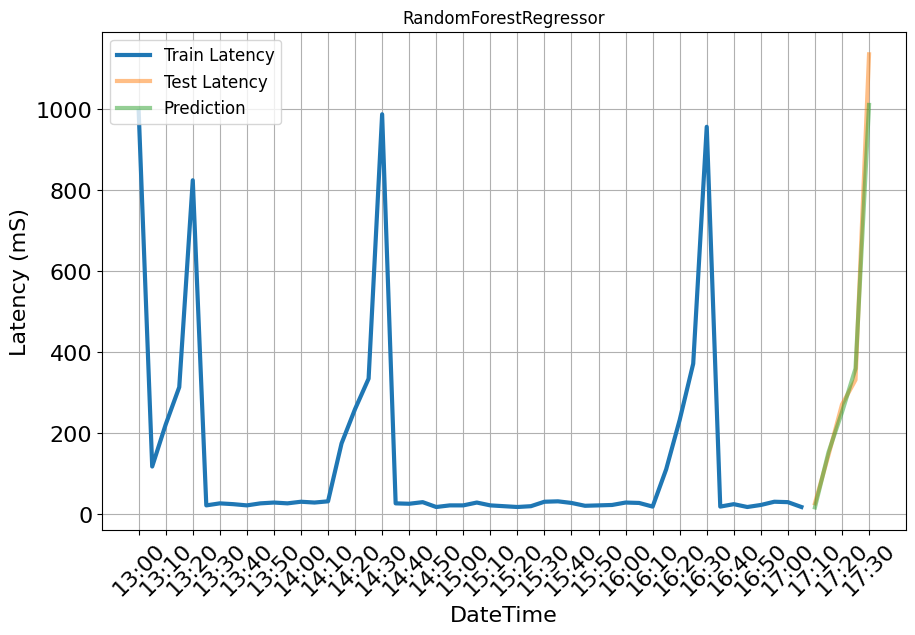

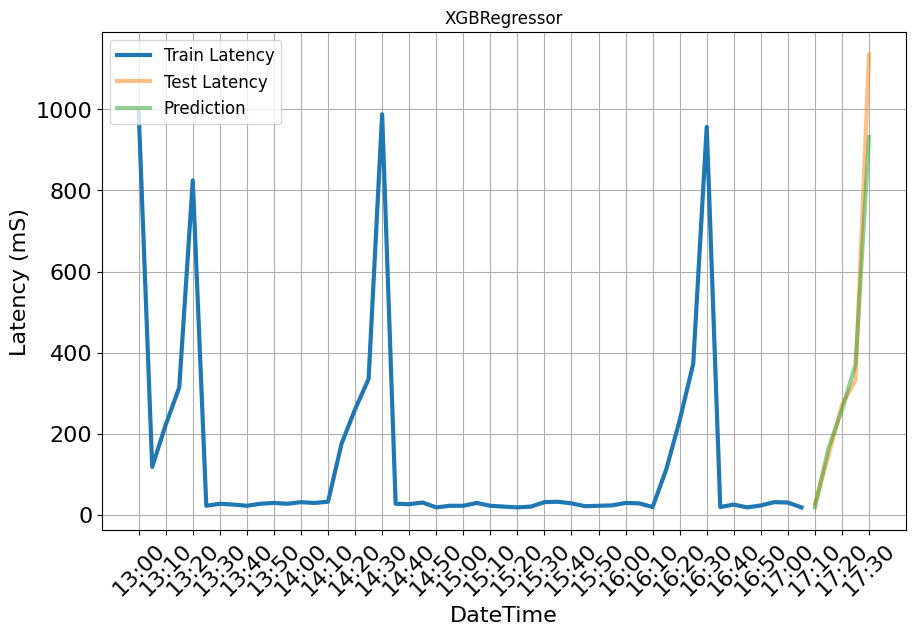

In [242]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/multistep_{idx}_plot.png')
    plt.show()

<AxesSubplot: >

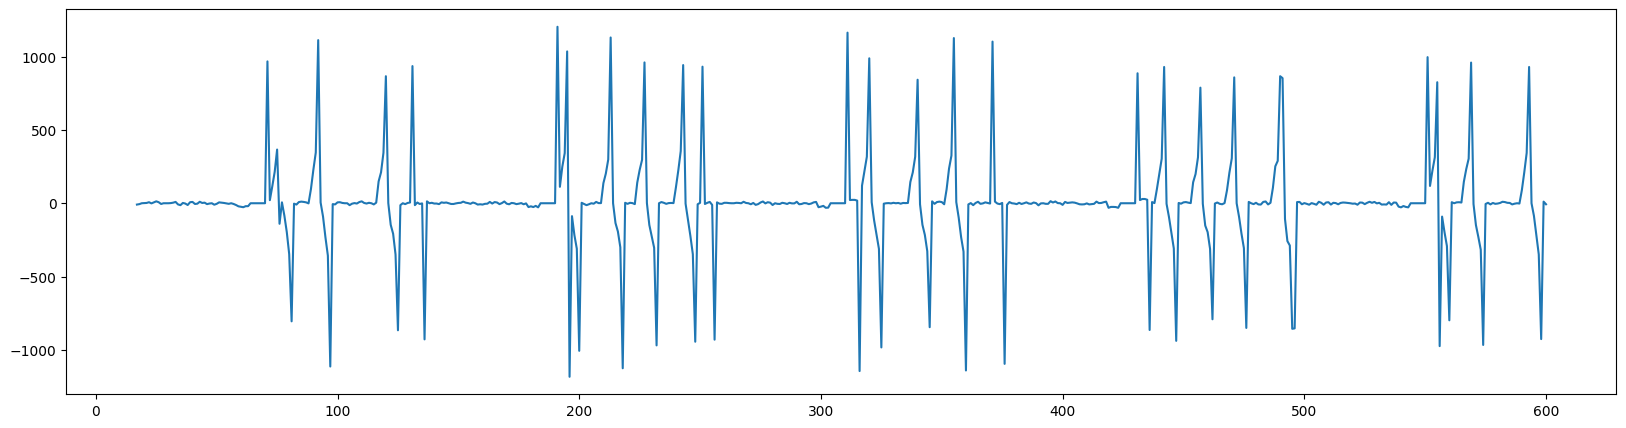

In [143]:
# Train Data After Preprocessing (Difference 5)
mlf.preprocess(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])['Latency'].plot(figsize=(20,5))

In [144]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.200181,0.072607,LGBMRegressor,59.6,0.143244,81.454282,6634.8
1,1,0.313028,0.103507,XGBRegressor,52.2,0.093778,94.190233,8871.8
2,1,0.925898,0.102690,RandomForestRegressor,34.0,0.079053,56.338264,3174.0
3,2,0.213920,0.056726,LGBMRegressor,22.0,0.119738,26.855167,721.2
4,2,0.276357,0.071449,XGBRegressor,23.6,0.096300,26.585710,706.8
5,2,1.168131,0.176205,RandomForestRegressor,21.2,0.085089,24.149534,583.2
6,3,0.164837,0.055677,LGBMRegressor,9.0,0.036671,14.690133,215.8
7,3,0.296087,0.070804,XGBRegressor,19.0,0.087945,23.962471,574.2
8,3,1.165272,0.107999,RandomForestRegressor,11.8,0.068564,14.078352,198.2
9,4,0.297864,0.085106,LGBMRegressor,40.6,0.110062,80.263317,6442.2


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LGBMRegressor,0.219200,0.067529,32.8,0.102429,50.815725,3503.5
RandomForestRegressor,1.118984,0.119467,26.2,0.092316,38.184147,1834.8
XGBRegressor,0.340434,0.090195,37.8,0.109403,59.552851,4722.5


### ML-SingleStep

In [237]:
DATASET_MAIN_DIR = 'data_new'

singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    test = test.drop(['Day', 'DateTime'], axis=1)

    for model in models:
        mlf = MLForecast(
            models = model,
            lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            freq = 1,
            target_transforms=[Differences([5])],
            lag_transforms={
            1: [ExpandingStd()],
            #3: [RollingMean(window_size=3, min_samples=1)],
            6: [RollingMean(window_size=6, min_samples=1)],
            #9: [RollingMean(window_size=3, min_samples=1)],
            #12: [RollingMean(window_size=12, min_samples=1)]
            },
        )
        train[ID_COL] = train[ID_COL].astype(int)
        test[ID_COL] = test[ID_COL].astype(int)
        t1 = time.perf_counter()
        mlf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])
        t2 = time.perf_counter()
        #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
        preds = mlf.predict(len(test), X_df=test.drop(TARGET, axis=1))
        t3 = time.perf_counter()
        # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
        preds = preds.merge(test, on=['time_idx', 'unique_id'])
        metrics_dict = {}
        metrics_dict['Fold'] = counter
        metrics_dict['Fold_TrainTime'] = t2-t1
        metrics_dict['Fold_PredictTime'] = t3-t2
        # for estimator in models:
        estimator_name = model.__class__.__name__
        preds[estimator_name] = preds[estimator_name].astype(int)
        metrics_dict['Model'] = estimator_name
        metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
        metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
        metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
        singlestep_model_metrics.append(metrics_dict)

        if counter == 4:
            singlestep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
            singlestep_last_fold_df['Model'] = estimator_name
            test = pd.read_excel(test_path)
            singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
            singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

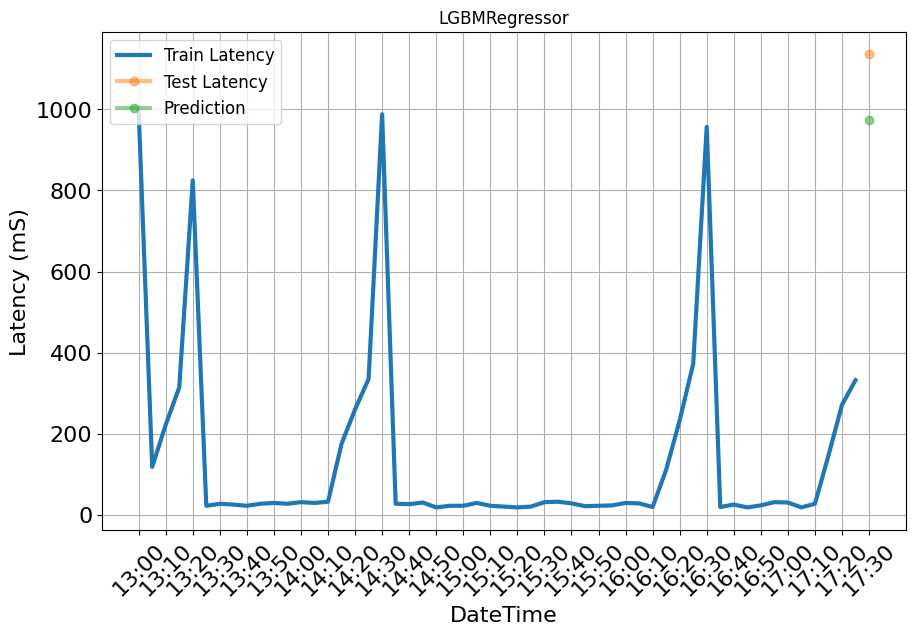

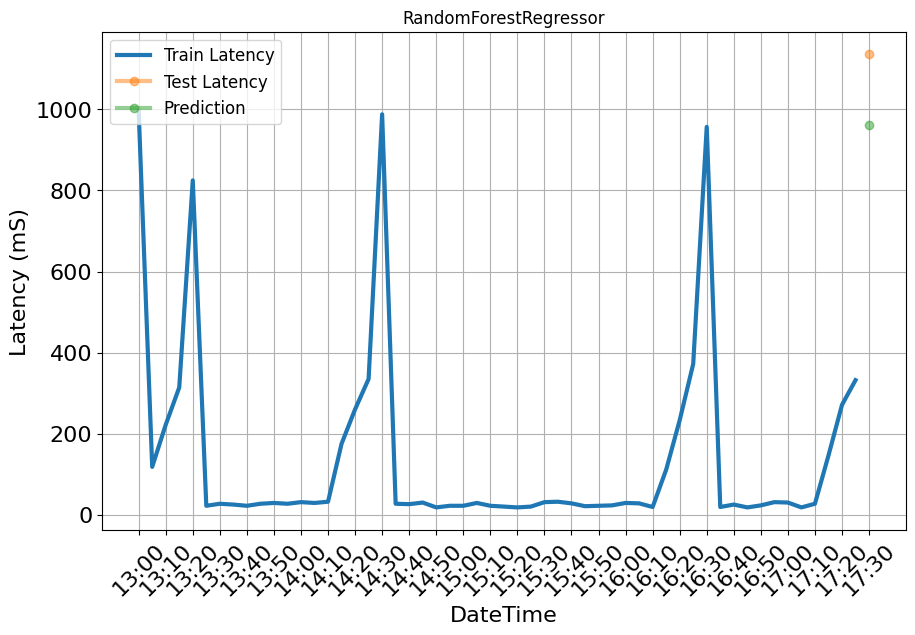

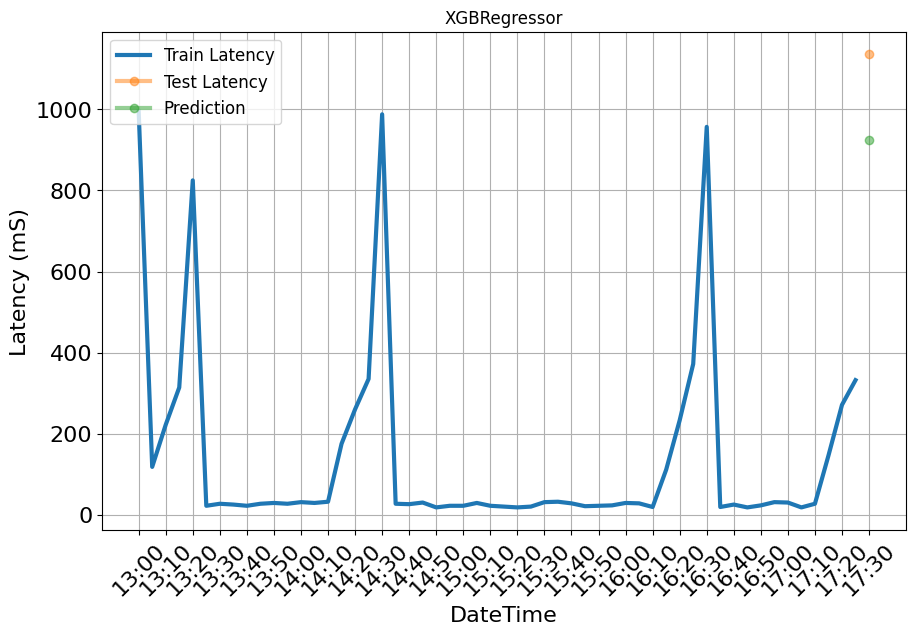

In [243]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/singlestep_{idx}_plot.png')
    plt.show()

<AxesSubplot: >

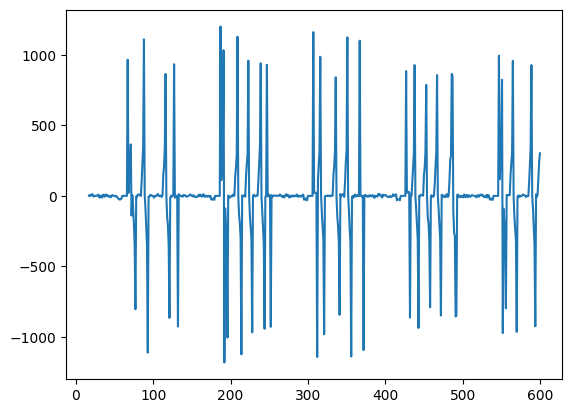

In [137]:
# Train Data After Preprocessing (Difference 5)
mlf.preprocess(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL, static_features=[ID_COL])['Latency'].plot()

In [138]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.133157,0.021428,LGBMRegressor,143.0,0.173333,143.0,20449.0
1,1,0.349782,0.021095,XGBRegressor,192.0,0.232727,192.0,36864.0
2,1,0.649054,0.017096,RandomForestRegressor,142.0,0.172121,142.0,20164.0
3,1,0.015341,0.009128,LinearRegression,189.0,0.229091,189.0,35721.0
4,2,0.094276,0.018732,LGBMRegressor,23.0,0.023279,23.0,529.0
5,2,0.209703,0.023310,XGBRegressor,135.0,0.136640,135.0,18225.0
6,2,0.654333,0.016388,RandomForestRegressor,89.0,0.090081,89.0,7921.0
7,2,0.016268,0.009924,LinearRegression,390.0,0.394737,390.0,152100.0
8,3,0.140635,0.022749,LGBMRegressor,7.0,0.007315,7.0,49.0
9,3,0.212914,0.023254,XGBRegressor,52.0,0.054336,52.0,2704.0


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LGBMRegressor,0.114881,0.020215,83.75,0.086633,83.75,11817.75
LinearRegression,0.015586,0.009855,402.25,0.400041,402.25,183799.75
RandomForestRegressor,0.634422,0.016634,108.25,0.111116,108.25,14859.75
XGBRegressor,0.236778,0.022212,147.75,0.152581,147.75,25684.25


# ARIMA

### MultiStep

In [245]:
AutoARIMA(seasonal=False).__class__.__name__

AutoARIMA(seasonal=True).__class__.__name__

'AutoARIMA'

In [6]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['Day', 'DateTime'], axis=1)

    train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=False)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=False).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    multistep_model_metrics.append(metrics_dict)

    filt_preds = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
    filt_preds['Fold'] = counter
    filt_preds['Model'] = 'ARIMA'
    all_multistep_results.append(filt_preds)

    if counter == 4:
        multistep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        multistep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1

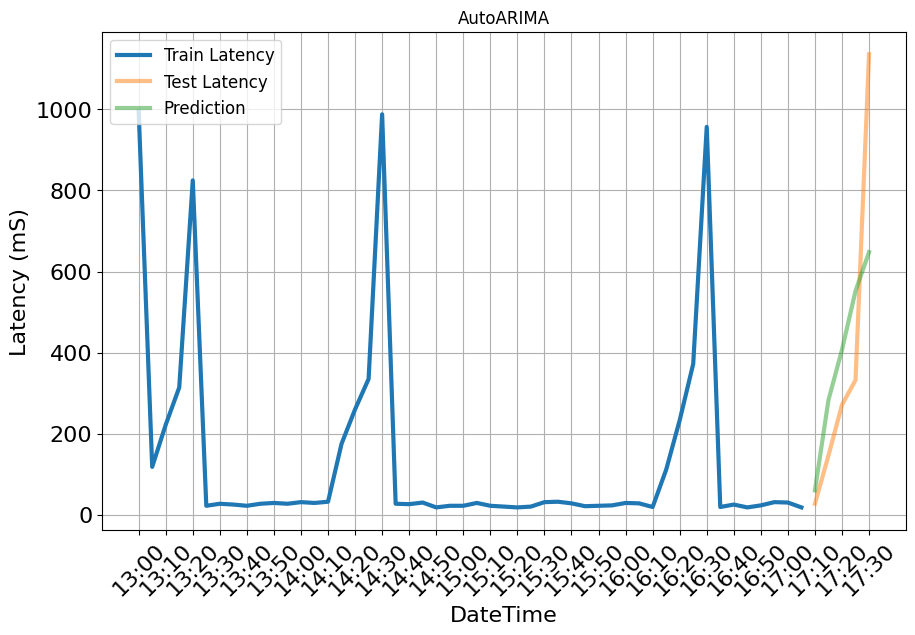

In [335]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/multistep_ARIMA_{idx}_plot.png')
    plt.show()

In [311]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.790,0.006,AutoARIMA,301.200,0.778,387.798,150387.200
1,2,1.519,0.009,AutoARIMA,179.400,1.120,199.821,39928.600
2,3,1.111,0.008,AutoARIMA,145.200,0.687,174.262,30367.200
3,4,0.788,0.006,AutoARIMA,202.800,0.751,254.911,64979.600


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,1.052,0.007,207.150,0.834,254.198,71415.650


### SingleStep

In [313]:
DATASET_MAIN_DIR = 'data_new'

singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    test = test.drop(['Day', 'DateTime'], axis=1)

    train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=False)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=False).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    singlestep_model_metrics.append(metrics_dict)

    if counter == 4:
        singlestep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        singlestep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

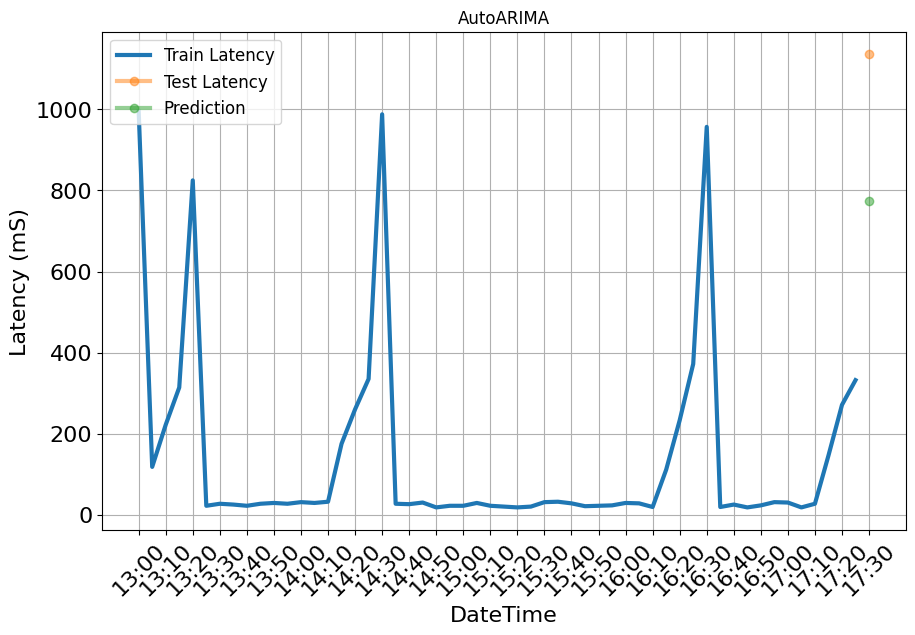

In [336]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/singlestep_ARIMA_{idx}_plot.png')
    plt.show()

In [316]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,1.993,0.006,AutoARIMA,138.000,0.167,138.000,19044.000
1,2,1.379,0.007,AutoARIMA,320.000,0.324,320.000,102400.000
2,3,1.378,0.006,AutoARIMA,290.000,0.303,290.000,84100.000
3,4,0.996,0.007,AutoARIMA,495.000,0.436,495.000,245025.000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,1.436,0.006,310.750,0.307,310.750,112642.250


# SARIMA

### MultiStep

In [7]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['Day', 'DateTime'], axis=1)

    train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=True, start_P=1, start_Q=0, d=1)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=True).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    multistep_model_metrics.append(metrics_dict)

    filt_preds = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
    filt_preds['Fold'] = counter
    filt_preds['Model'] = 'SARIMA'
    all_multistep_results.append(filt_preds)

    if counter == 4:
        multistep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        multistep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1

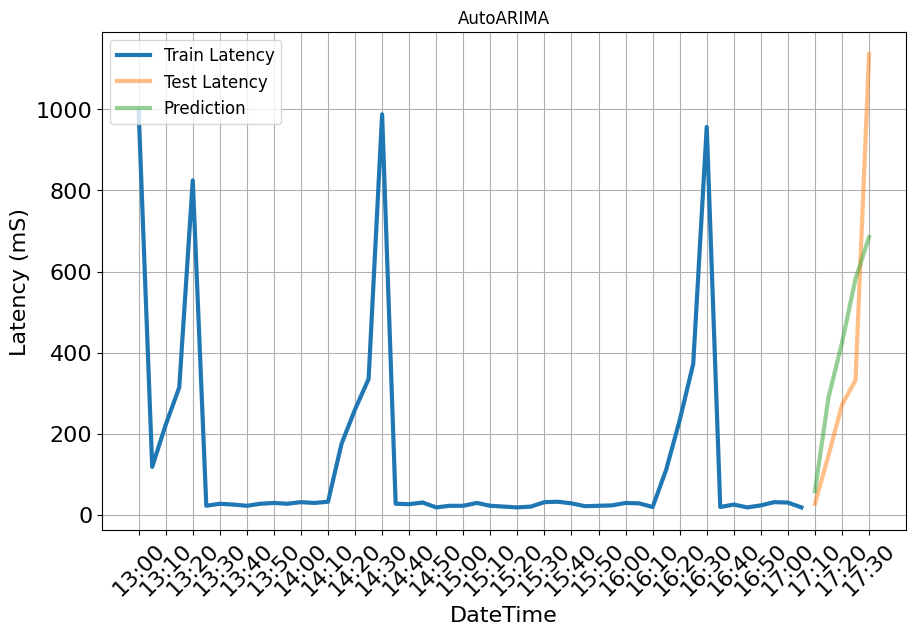

In [338]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/multistep_SARIMA_{idx}_plot.png')
    plt.show()

In [327]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,3.208,0.006,AutoARIMA,306.800,0.862,388.496,150928.800
1,2,1.801,0.007,AutoARIMA,184.200,1.170,199.205,39682.600
2,3,1.407,0.006,AutoARIMA,149.600,0.726,166.487,27718.000
3,4,3.530,0.011,AutoARIMA,205.600,0.768,249.287,62144.000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,2.486,0.007,211.550,0.882,250.869,70118.350


### SingleStep

In [339]:
DATASET_MAIN_DIR = 'data_new'

singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    test = test.drop(['Day', 'DateTime'], axis=1)

    train = train[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]
    test = test[[ID_COL, TIME_COL, TARGET, 'Request', 'CPU_Usage', 'Memory_Usage']]

    sf = StatsForecast(
        models = [AutoARIMA(seasonal=True, start_P=1, start_Q=0, d=1)],
        freq = 1
        )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    sf.fit(train, id_col=ID_COL, target_col=TARGET, time_col=TIME_COL)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = sf.predict(h=len(test), X_df=test.drop(TARGET, axis=1))
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)
    preds = preds.merge(test, on=['time_idx', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = AutoARIMA(seasonal=False).__class__.__name__
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds[TARGET], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds[TARGET], y_pred=preds[estimator_name], squared=True)
    singlestep_model_metrics.append(metrics_dict)

    if counter == 4:
        singlestep_last_fold_df = preds[[estimator_name, TARGET, TIME_COL]].rename(columns={estimator_name: 'Prediction'})
        singlestep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path)
        singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'time_idx']], on='time_idx', how='left')
        singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

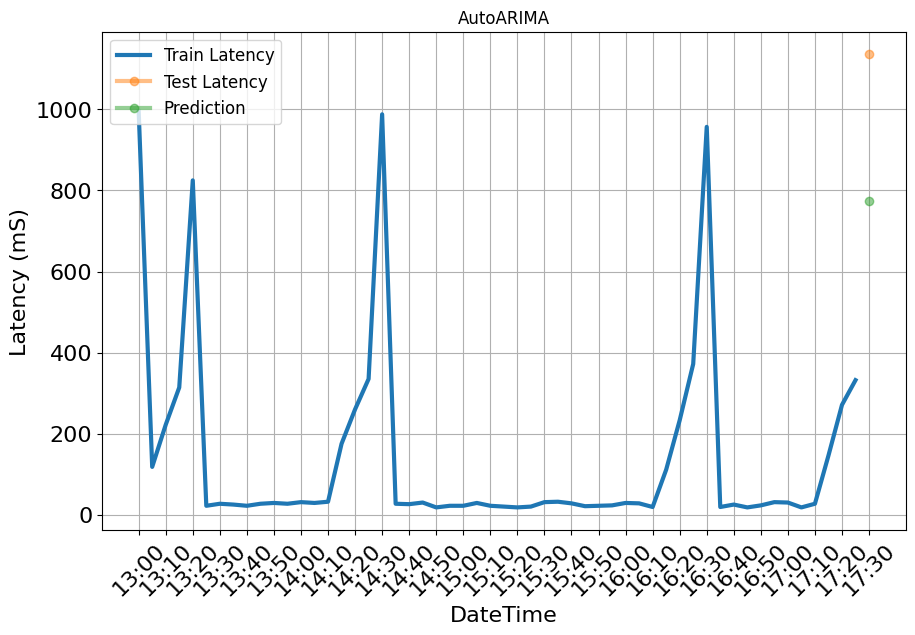

In [340]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['Latency'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/singlestep_SARIMA_{idx}_plot.png')
    plt.show()

In [341]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,1.900,0.007,AutoARIMA,6.000,0.007,6.000,36.000
1,2,2.747,0.006,AutoARIMA,239.000,0.242,239.000,57121.000
2,3,1.446,0.007,AutoARIMA,240.000,0.251,240.000,57600.000
3,4,1.546,0.005,AutoARIMA,362.000,0.319,362.000,131044.000


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
AutoARIMA,1.910,0.006,211.750,0.205,211.750,61450.250


# LSTM

### MultiStep

In [8]:
multistep_last_fold_preds = []
multistep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'multistep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    val = test.copy()
    test = test.drop(['Day', 'DateTime'], axis=1)

    future_exog_features = [c for c in train.columns if c not in [ID_COL, TIME_COL, TARGET, 'CPU_Usage', 'Memory_Usage']]
    historical_exog_features = ['CPU_Usage', 'Memory_Usage']
    train = train.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
    test = test.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})

    nf = NeuralForecast(
    models=[LSTM(h=5, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=500,
                 futr_exog_list=future_exog_features,
                 hist_exog_list=historical_exog_features,
                 )
    ],
    freq='5m'
    )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    nf.fit(df=train)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = nf.predict(futr_df=test)
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)

    preds = preds.merge(test, on=['ds', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = 'LSTM'
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=True)
    multistep_model_metrics.append(metrics_dict)

    filt_preds = preds[[estimator_name, 'y', 'ds']].rename(columns={estimator_name: 'Prediction', 'y': TARGET, 'ds': TIME_COL}).merge(val[['DateTime', 'time_idx']], on='time_idx', how='left')
    filt_preds['Fold'] = counter
    filt_preds['Model'] = 'LSTM'
    all_multistep_results.append(filt_preds)

    if counter == 4:
        multistep_last_fold_df = preds[[estimator_name, 'y', 'ds']].rename(columns={estimator_name: 'Prediction'})
        multistep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path).rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
        multistep_last_fold_df = multistep_last_fold_df.merge(test[['DateTime', 'ds']], on='ds', how='left')
        multistep_last_fold_preds.append(multistep_last_fold_df)
    counter += 1

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

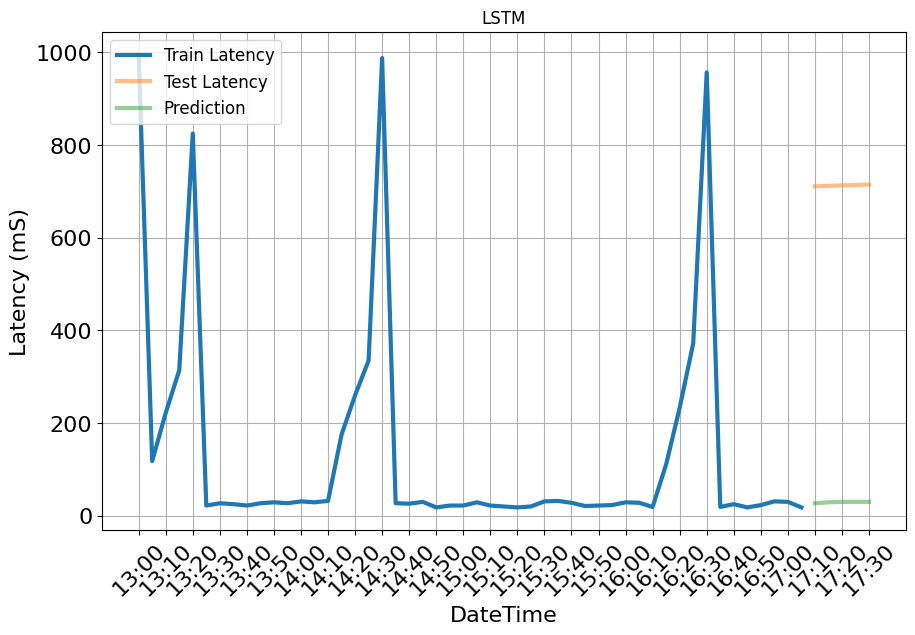

In [47]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'multistep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
multistep_last_fold_preds_df = pd.concat(multistep_last_fold_preds, axis=0)


for idx, grp in multistep_last_fold_preds_df.groupby('Model'):
    # display(last_fold_train)
    # display(grp)
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['ds'].plot(label='Test Latency', lw=3, alpha=0.5)
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5)
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/multistep_LSTM_{idx}_plot.png')
    plt.show()

In [48]:
multistep_results = pd.DataFrame(multistep_model_metrics)
display(multistep_results)
display(multistep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.822236,0.664906,LSTM,467.4,0.897210,583.751146,340765.4
1,2,0.804077,0.664161,LSTM,331.0,0.769567,467.384424,218448.2
2,3,0.894439,0.760341,LSTM,313.8,0.769164,454.186526,206285.4
3,4,0.869799,0.631419,LSTM,353.2,0.714780,526.537748,277242.0


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LSTM,0.847638,0.680207,366.35,0.78768,507.964961,260685.25


### SingleStep

In [57]:
singlestep_last_fold_preds = []
singlestep_model_metrics = []
counter = 1
for dataset_id in dataset_idx_list:
    train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_id}.xlsx')
    test_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_test_{dataset_id}.xlsx')

    train = pd.read_excel(train_path)
    test = pd.read_excel(test_path)

    train = train.drop(['Day', 'DateTime'], axis=1)
    test = test.drop(['Day', 'DateTime'], axis=1)

    future_exog_features = [c for c in train.columns if c not in [ID_COL, TIME_COL, TARGET, 'CPU_Usage', 'Memory_Usage']]
    historical_exog_features = ['CPU_Usage', 'Memory_Usage']
    train = train.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
    test = test.rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})

    nf = NeuralForecast(
    models=[LSTM(h=1, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=5,
                 futr_exog_list=future_exog_features,
                 hist_exog_list=historical_exog_features,
                 )
    ],
    freq='5m'
    )
    
    train[ID_COL] = train[ID_COL].astype(int)
    test[ID_COL] = test[ID_COL].astype(int)

    t1 = time.perf_counter()
    nf.fit(df=train)
    t2 = time.perf_counter()
    #print(f'Training Time For {model.__class__.__name__}:', t2-t1)
    preds = nf.predict(futr_df=test)
    t3 = time.perf_counter()
    # print(f'Prediction Time For {model.__class__.__name__}:', t3-t2)

    preds = preds.merge(test, on=['ds', 'unique_id'])
    metrics_dict = {}
    metrics_dict['Fold'] = counter
    metrics_dict['Fold_TrainTime'] = t2-t1
    metrics_dict['Fold_PredictTime'] = t3-t2
    # for estimator in models:
    estimator_name = 'LSTM'
    preds[estimator_name] = preds[estimator_name].astype(int)
    metrics_dict['Model'] = estimator_name
    metrics_dict[f'MAE'] = mean_absolute_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'MAPE'] = mean_absolute_percentage_error(y_true=preds['y'], y_pred=preds[estimator_name])
    metrics_dict[f'RMSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=False)
    metrics_dict[f'MSE'] = mean_squared_error(y_true=preds['y'], y_pred=preds[estimator_name], squared=True)
    singlestep_model_metrics.append(metrics_dict)

    if counter == 4:
        singlestep_last_fold_df = preds[[estimator_name, 'y', 'ds']].rename(columns={estimator_name: 'Prediction'})
        singlestep_last_fold_df['Model'] = estimator_name
        test = pd.read_excel(test_path).rename(columns={ID_COL: 'unique_id', TIME_COL: 'ds', TARGET: 'y'})
        singlestep_last_fold_df = singlestep_last_fold_df.merge(test[['DateTime', 'ds']], on='ds', how='left')
        singlestep_last_fold_preds.append(singlestep_last_fold_df)
    counter += 1

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

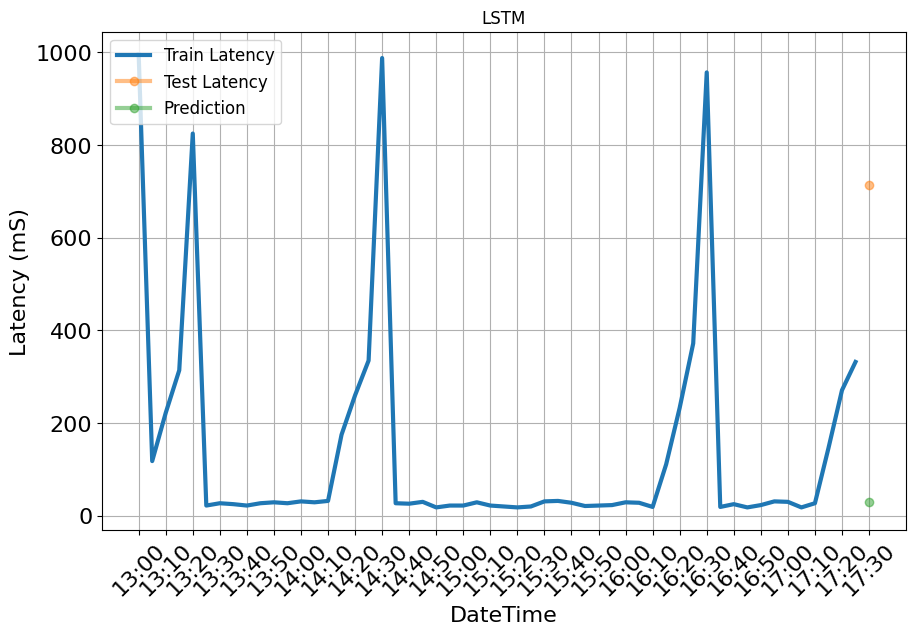

In [58]:
last_fold_train_path = os.path.join(DATASET_MAIN_DIR, f'singlestep_train_{dataset_idx_list[-1]}.xlsx')
last_fold_train = pd.read_excel(last_fold_train_path)
singlestep_last_fold_preds_df = pd.concat(singlestep_last_fold_preds, axis=0)


for idx, grp in singlestep_last_fold_preds_df.groupby('Model'):
    # display(last_fold_train)
    # display(grp)
    last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00'].set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Train Latency', title=idx, fontsize=16, lw=3)
    grp.set_index('DateTime')['ds'].plot(label='Test Latency', lw=3, alpha=0.5, marker='o')
    grp.set_index('DateTime')['Prediction'].plot(label='Prediction', lw=3, alpha=0.5, marker='o')
    x_axis_values = pd.concat([last_fold_train[last_fold_train['DateTime'] >= '2023-03-06 13:00:00']['DateTime'], grp['DateTime']], axis=0)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
    plt.ylabel('Latency (mS)', fontsize=16)
    plt.xlabel('DateTime', fontsize=16)
    plt.grid()
    plt.autoscale(tight=False)
    plt.savefig(f'plots_new/singlestep_LSTM_{idx}_plot.png')
    plt.show()

In [59]:
singlestep_results = pd.DataFrame(singlestep_model_metrics)
display(singlestep_results)
display(singlestep_results.groupby('Model')[['Fold_TrainTime', 'Fold_PredictTime', 'MAE', 'MAPE', 'RMSE', 'MSE']].mean())

,Fold,Fold_TrainTime,Fold_PredictTime,Model,MAE,MAPE,RMSE,MSE
0,1,0.904676,0.406256,LSTM,795.0,0.963636,795.0,632025.0
1,2,0.872191,0.458984,LSTM,958.0,0.969636,958.0,917764.0
2,3,1.032400,0.436257,LSTM,930.0,0.971787,930.0,864900.0
3,4,1.036458,0.609055,LSTM,1107.0,0.974472,1107.0,1225449.0


,Fold_TrainTime,Fold_PredictTime,MAE,MAPE,RMSE,MSE
Model,,,,,,
LSTM,0.961431,0.477638,947.5,0.969883,947.5,910034.5


# All plot

In [25]:
filt_df = df[['DateTime', 'Latency', 'time_idx']]
filt_df = filt_df[(filt_df['DateTime'].dt.day == 6) & (filt_df['DateTime'].dt.hour >= 11)]
filt_df

,DateTime,Latency,time_idx
1572,2023-03-06 11:00:00,29,637
1573,2023-03-06 11:05:00,32,638
1574,2023-03-06 11:10:00,32,639
1575,2023-03-06 11:15:00,21,640
1576,2023-03-06 11:20:00,30,641
...,...,...,...
1651,2023-03-06 17:35:00,22,716
1652,2023-03-06 17:40:00,25,717
1653,2023-03-06 17:45:00,23,718
1654,2023-03-06 17:50:00,31,719


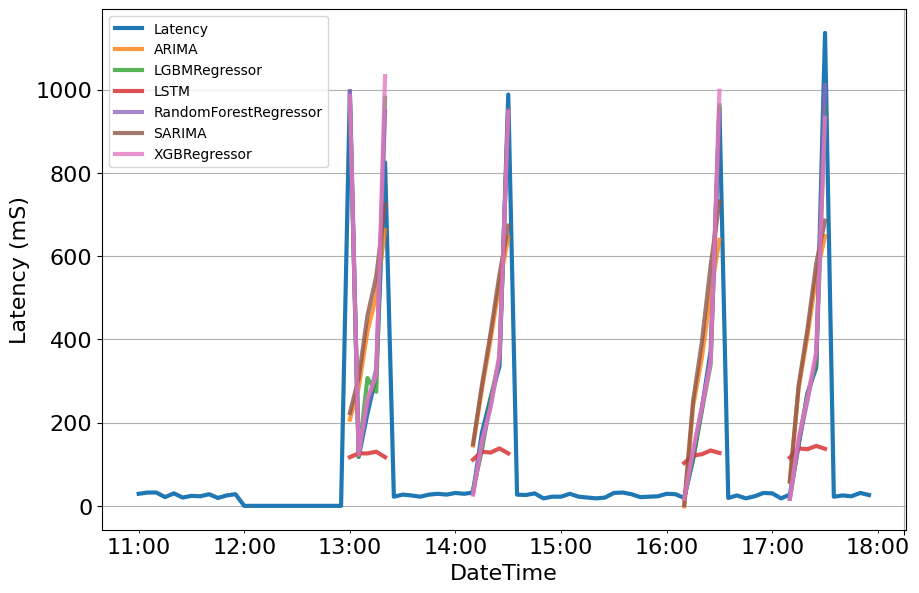

In [36]:
temp_df = pd.concat(all_multistep_results, axis=0)

filt_df.set_index('DateTime')['Latency'].plot(figsize=(9,6), label='Latency', fontsize=16, lw=3)
for idx, grp in temp_df.groupby('Model'):
    grp = grp.set_index('DateTime')
    grp = grp.reindex(pd.DatetimeIndex(filt_df.set_index('DateTime').index), fill_value=np.nan)
    grp['Prediction'].plot(label=idx, lw=3, alpha=0.8)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
#plt.xticks(x_axis_values.values[::2], labels=x_axis_values.dt.strftime('%H:%M').values[::2], rotation=45)
plt.ylabel('Latency (mS)', fontsize=16)
plt.xlabel('DateTime', fontsize=16)
plt.grid()
plt.autoscale(tight=False)
plt.savefig(f'plots_new/multistep_all_models_plot_2.png')
plt.show()